# Analysis

## City Analysis

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

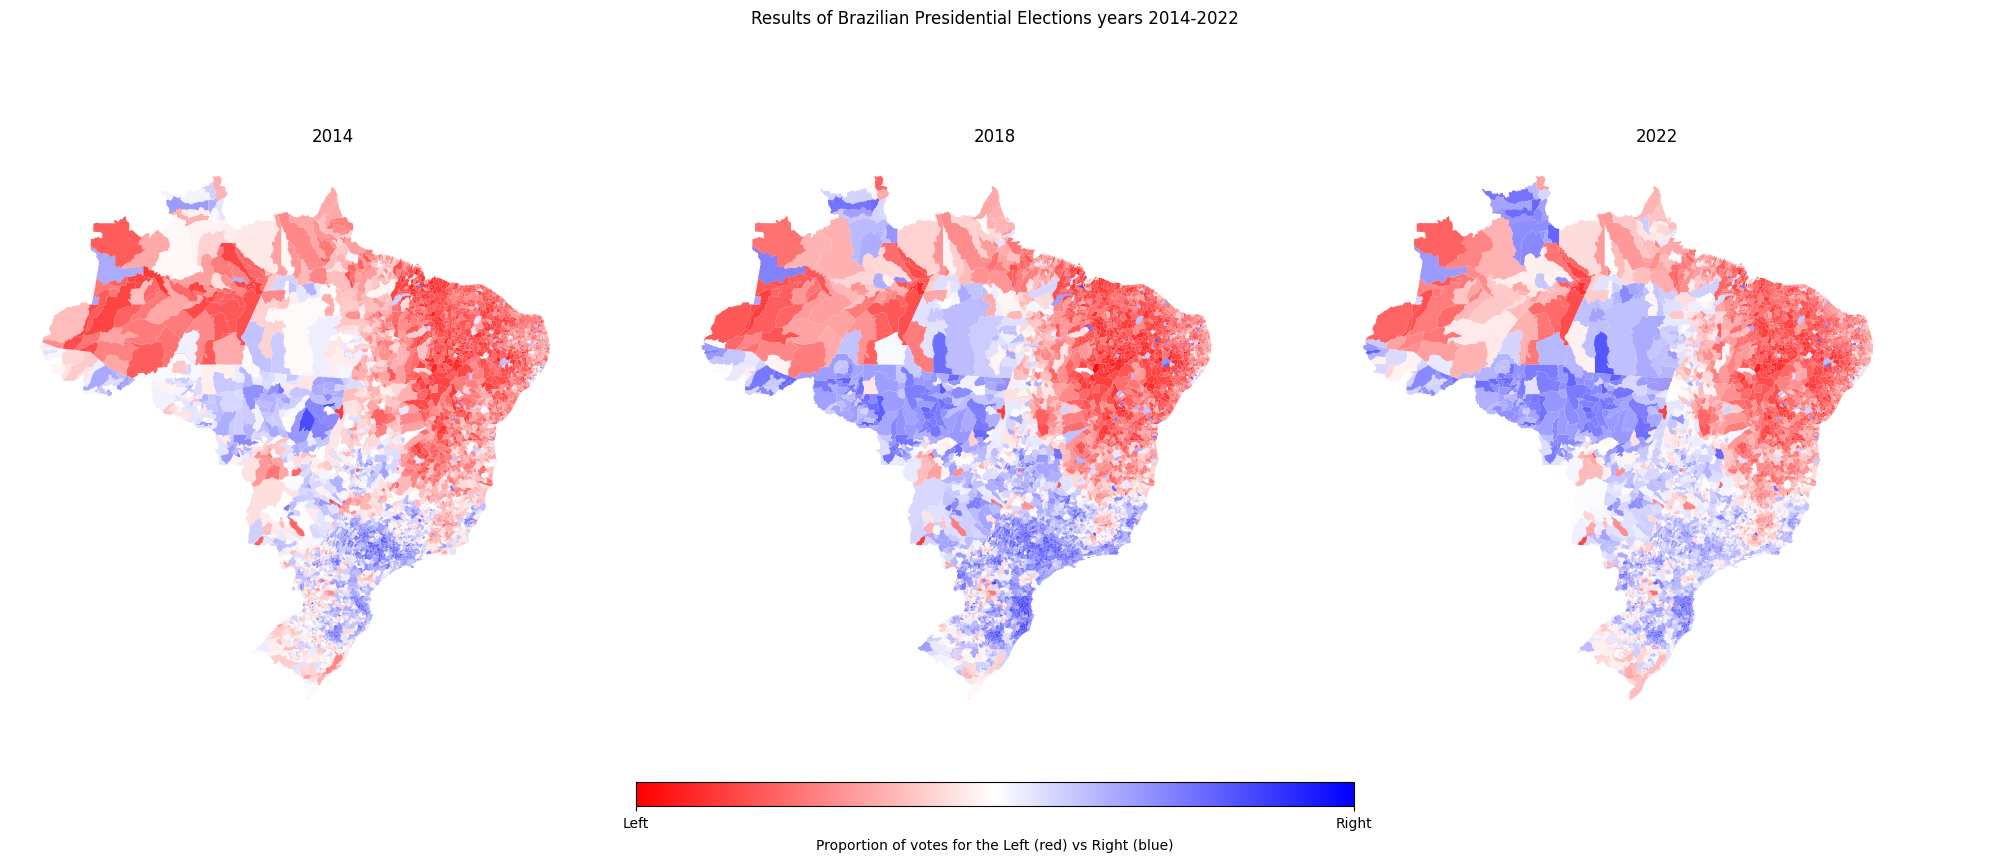

In [2]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20 / 2.414))
gradient = True

# Define normalization and reversed colormap once
norm = colors.Normalize(vmin=0, vmax=1)
cmap = plt.get_cmap("bwr")  # reversed: red to blue

for i, year in enumerate([2014, 2018, 2022]):
    file = gpd.read_file(f"data/merged_{year}.gpkg")
    title = f"{year}"

    if gradient:
        # Apply gradient color
        file["color_grad"] = file.apply(
            lambda row: cmap(norm(row["pc_votos_validos"] if row["sg_partido"] == "PT" else 1 - row["pc_votos_validos"])),
            axis=1
        )
        file.plot(color=file["color_grad"], ax=ax[i])
    else:
        file.plot(color=file["color"], ax=ax[i])

    ax[i].set_title(title)
    ax[i].axis("off")

# Tight layout first
fig.tight_layout()

# Add colorbar on top
if gradient:
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("bwr_r"), norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(
        sm,
        ax=ax,
        orientation="horizontal",
        fraction=0.03,
        pad=0.07,
        aspect=30,
    )
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["Left", "Right"])
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label("Proportion of votes for the Left (red) vs Right (blue)", size=10, labelpad=6)

fig.suptitle("Results of Brazilian Presidential Elections years 2014-2022")

plt.savefig("brazil_elections.png", dpi=300, bbox_inches="tight")

see which cities switched party and see why...
Idea: Think about nice (interactive) vizualization on how the cities switched left/right through out the years.

Maybe we can try to find any data possible for the cities and see which one correlates the most with te switch (if any)

data to look for: something about economic realities, public trust, media influence, and the national mood.

In [3]:
right_data = []

# Define ideology map
ideology_map = {
    "AÉCIO NEVES": "right",
    "DILMA": "left",
    "JAIR BOLSONARO": "right",
    "FERNANDO HADDAD": "left",
    "LULA": "left",
}

for year in [2014, 2018, 2022]:
    data = pd.read_csv(f'data/votacao_candidato-municipio_{year}.csv')
    data = data.rename(columns={'sg_uf': 'state', "nm_municipio": "city", "nm_urna_candidato": "candidate", "pc_votos_validos": "percentage", 'qt_votos_nom_validos': 'num of votes'})
    data["ideology"] = data["candidate"].map(ideology_map)
    data['total voters'] = (data['num of votes'] / data['percentage'].astype(float)).round()
    data = data[["city", "ideology", "percentage", 'total voters', 'state']]
    data['year'] = year
    data = data[data['ideology']=='right']
    
    right_data.append(data)

right_data = pd.concat(right_data, ignore_index=True)
right_data

,city,ideology,percentage,total voters,state,year
0,ACRELÂNDIA,right,0.6484,6286.0,AC,2014
1,ASSIS BRASIL,right,0.5184,4082.0,AC,2014
2,BRASILÉIA,right,0.6074,12435.0,AC,2014
3,BUJARI,right,0.6600,5391.0,AC,2014
4,CAPIXABA,right,0.7051,4958.0,AC,2014
...,...,...,...,...,...,...
17155,WINDHOEK,right,0.8857,35.0,ZZ,2022
17156,XANGAI,right,0.3316,187.0,ZZ,2022
17157,YANGON,right,NaN,NaN,ZZ,2022
17158,ZAGREB,right,0.3659,41.0,ZZ,2022


In [4]:
total_votes_right = right_data.groupby("year").apply(lambda x: (x["percentage"] * x["total voters"]).sum()).reset_index(name="total_votes_right")
total_votes_left = right_data.groupby("year").apply(lambda x: ((1 - x["percentage"]) * x["total voters"]).sum()).reset_index(name="total_votes_left")

total_votes_by_year = pd.merge(total_votes_right, total_votes_left, on="year")
total_votes_by_year

/tmp/ipykernel_30616/3020658629.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_votes_right = right_data.groupby("year").apply(lambda x: (x["percentage"] * x["total voters"]).sum()).reset_index(name="total_votes_right")
/tmp/ipykernel_30616/3020658629.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_votes_left = right_data.groupby("year").apply(lambda x: ((1 - x["percentage"]) * x["total 

,year,total_votes_right,total_votes_left
0,2014,5.104115e+07,5.450140e+07
1,2018,5.779785e+07,4.704119e+07
2,2022,5.820635e+07,6.034643e+07


In [5]:
# Group by year and state, calculate total right votes
total_votes_right = right_data.groupby(["year", "state"]).apply(
    lambda x: (x["percentage"] * x["total voters"]).sum()
).reset_index(name="total_votes_right")

# Group by year and state, calculate total left votes
total_votes_left = right_data.groupby(["year", "state"]).apply(
    lambda x: ((1 - x["percentage"]) * x["total voters"]).sum()
).reset_index(name="total_votes_left")

# Merge on both year and state
total_votes_by_year = pd.merge(total_votes_right, total_votes_left, on=["year", "state"])
total_votes_by_year['percentage_right'] = total_votes_by_year['total_votes_right']/ (total_votes_by_year['total_votes_right']+total_votes_by_year['total_votes_left'])
# Save to CSV (no index column in the file)
total_votes_by_year.to_csv("data/state_elections.csv", index=False)

/tmp/ipykernel_30616/1057889887.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_votes_right = right_data.groupby(["year", "state"]).apply(
/tmp/ipykernel_30616/1057889887.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_votes_left = right_data.groupby(["year", "state"]).apply(


/tmp/ipykernel_30616/2866479290.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_votes["state"] = pd.Categorical(right_votes["state"], categories=sorted_states, ordered=True)


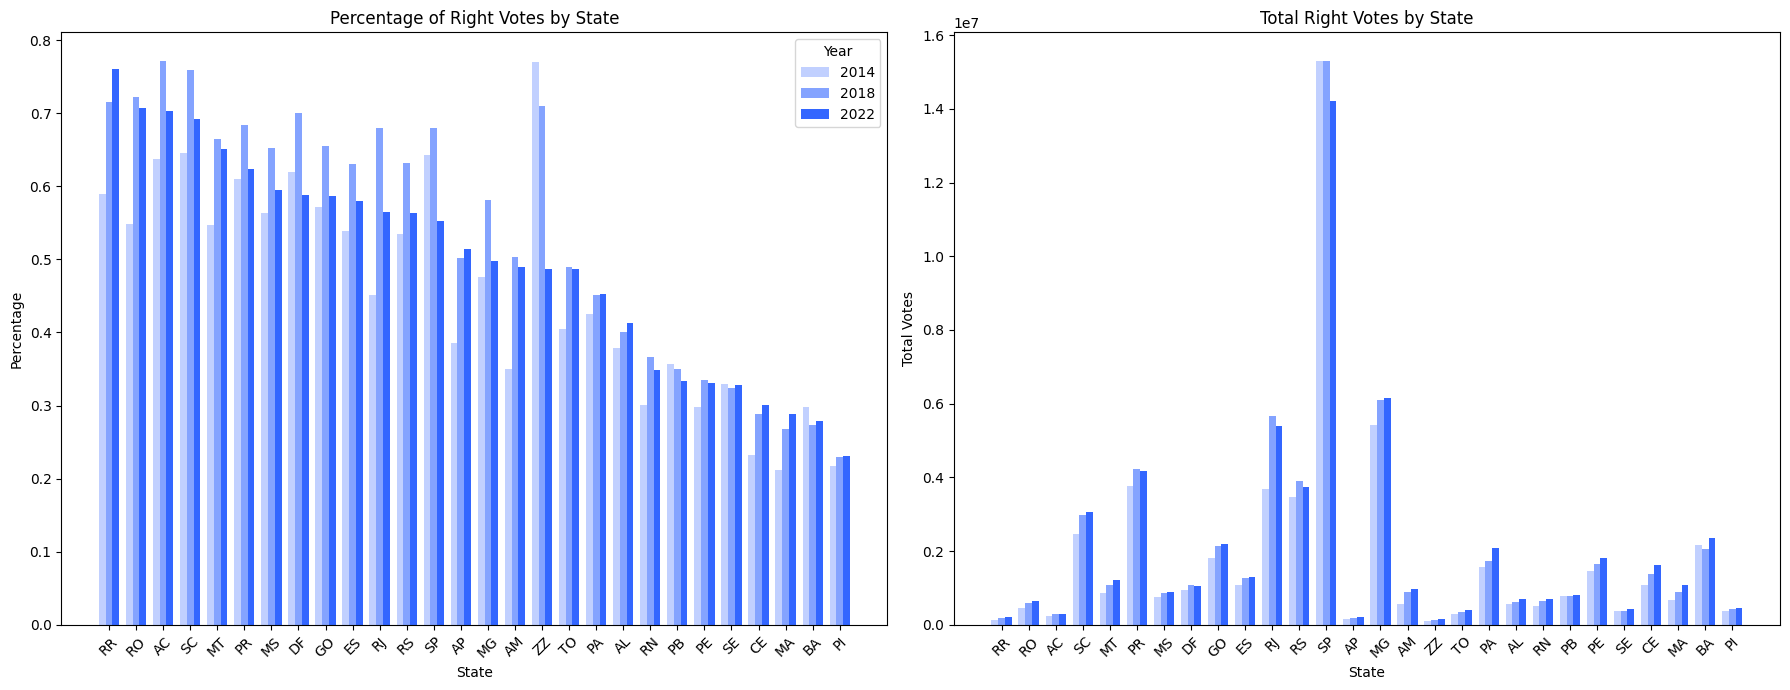

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assume this DataFrame has both percentage and total right votes
right_votes = total_votes_by_year[["year", "state", "percentage_right", "total_votes_right"]]

# 1. Sort states by 2022 percentage_right
top_2022 = right_votes[right_votes["year"] == 2022]
sorted_states = top_2022.sort_values(by="percentage_right", ascending=False)["state"].tolist()

# 2. Set categorical state ordering
right_votes["state"] = pd.Categorical(right_votes["state"], categories=sorted_states, ordered=True)
right_votes = right_votes.sort_values(by=["state", "year"])

# 3. Setup
years = sorted(right_votes["year"].unique())
states = sorted_states
x = np.arange(len(states))
width = 0.25

# Colors with varying opacity
alphas = {years[0]: 0.3, years[1]: 0.6, years[2]: 1.0}
colors = {year: (0.2, 0.4, 1.0, alphas[year]) for year in years}

# 4. Plotting side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharex=True)

# -- First subplot: percentage_right
for i, year in enumerate(years):
    data = right_votes[right_votes["year"] == year]
    ax1.bar(
        x + i * width - width,
        data["percentage_right"],
        width=width,
        label=str(year),
        color=colors[year]
    )
ax1.set_title("Percentage of Right Votes by State")
ax1.set_ylabel("Percentage")
ax1.set_xlabel("State")
ax1.set_xticks(x)
ax1.set_xticklabels(states, rotation=45)

# -- Second subplot: total_votes_right
for i, year in enumerate(years):
    data = right_votes[right_votes["year"] == year]
    ax2.bar(
        x + i * width - width,
        data["total_votes_right"],
        width=width,
        label=str(year),
        color=colors[year]
    )
ax2.set_title("Total Right Votes by State")
ax2.set_ylabel("Total Votes")
ax2.set_xlabel("State")
ax2.set_xticks(x)
ax2.set_xticklabels(states, rotation=45)

# Legend only once
ax1.legend(title="Year")
plt.tight_layout()
plt.show()

In [7]:
right_data['state'].nunique()

28

/tmp/ipykernel_30616/1458741614.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("bwr_r")


ValueError: autodetected range of [nan, nan] is not finite

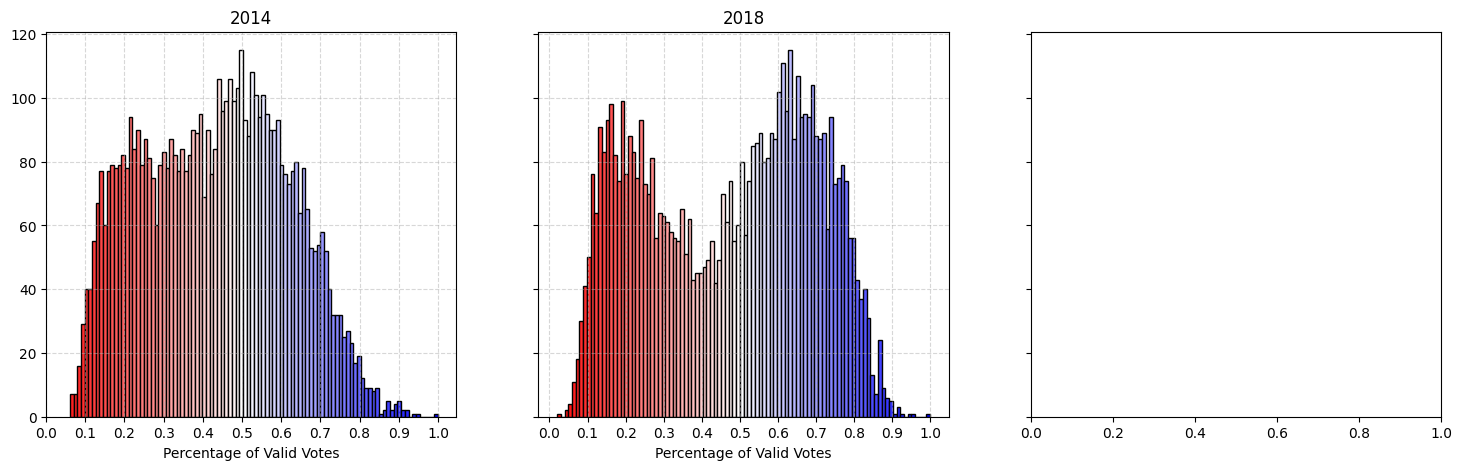

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

n_bins = 100
cmap = cm.get_cmap("bwr_r")

# First plot: number of municipalities
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, year in enumerate([2014, 2018, 2022]):
    ax = axes[i]
    data_year = right_data[right_data["year"] == year]
    values = data_year["percentage"]
    
    counts, bins = np.histogram(values, bins=n_bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    norm = np.clip(bin_centers, 0, 1)
    colors = cmap(norm)

    for j in range(n_bins):
        ax.bar(bin_centers[j], counts[j], width=(bins[1] - bins[0]), color=colors[j], edgecolor="black")

    ax.set_title(year)
    ax.set_xlabel("Percentage of Valid Votes")
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Number of Municipalities")
fig.suptitle("Right-Wing Vote Share per Municipality")
plt.subplots_adjust(top=0.85)
plt.tight_layout()
plt.show()

# Second plot: weighted by total voters
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, year in enumerate([2014, 2018, 2022]):
    ax = axes[i]
    data_year = right_data[right_data["year"] == year]

    counts, bins = np.histogram(data_year["percentage"], bins=n_bins, weights=data_year["total voters"])
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    norm = np.clip(bin_centers, 0, 1)
    colors = cmap(norm)

    for j in range(n_bins):
        ax.bar(bin_centers[j], counts[j], width=(bins[1] - bins[0]), color=colors[j], edgecolor="black")

    ax.set_title(year)
    ax.set_xlabel("Percentage of Valid Votes")
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Total Votes")
fig.suptitle("Right-Wing Vote Share per Municipality (Weighted by Voters)")
plt.subplots_adjust(top=0.85)
plt.tight_layout()
plt.show()

In [ ]:
## here i want to plor rate of change from# Step 1: Filter for years 2018 and 2022
filtered = right_data[right_data["year"].isin([2018, 2022])]

# Step 2: Pivot so each city has one row with 2018 and 2022 percentages
pivoted = filtered.pivot_table(
    index=["city", "state"],
    columns="year",
    values="percentage"
).reset_index()

# Step 3: Rename columns for clarity
pivoted = pivoted.rename(columns={2018: "percentage_2018", 2022: "percentage_2022"})

# Step 4: Compute the difference
pivoted["perc_diff_2022_vs_2018"] = (pivoted["percentage_2022"] - pivoted["percentage_2018"]).abs()

# Step 5: Merge back into right_data
right_data = pd.merge(
    right_data,
    pivoted[["city", "state", "perc_diff_2022_vs_2018"]],
    on=["city", "state"],
    how="left"
)

In [ ]:
right_data

,city,ideology,percentage,total voters,state,year,perc_diff_2022_vs_2018
0,ACRELÂNDIA,right,0.6484,6286.0,AC,2014,0.0143
1,ASSIS BRASIL,right,0.5184,4082.0,AC,2014,0.0048
2,BRASILÉIA,right,0.6074,12435.0,AC,2014,0.0229
3,BUJARI,right,0.6600,5391.0,AC,2014,0.0803
4,CAPIXABA,right,0.7051,4958.0,AC,2014,0.0562
...,...,...,...,...,...,...,...
17155,WINDHOEK,right,0.8857,35.0,ZZ,2022,0.2746
17156,XANGAI,right,0.3316,187.0,ZZ,2022,0.4272
17157,YANGON,right,NaN,NaN,ZZ,2022,NaN
17158,ZAGREB,right,0.3659,41.0,ZZ,2022,0.2495


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter for 2022 data only
data_2022 = right_data[right_data["year"] == 2022].copy()

# Step 2: Drop rows with missing difference (if any)
data_2022 = data_2022.dropna(subset=["perc_diff_2022_vs_2018_y"])

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data_2022,
    x="total voters",
    y="perc_diff_2022_vs_2018_y",
    alpha=0.7
)
plt.xscale("log")
plt.title("Change in Right Vote Percentage (2022 vs 2018) by City Size")
plt.xlabel("Total Voters in 2022")
plt.ylabel("Change in % Right Vote (2022 - 2018)")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.tight_layout()
plt.show()

In [ ]:
right_data.loc[right_data['total voters'].idxmax()]

In [ ]:
right_data[right_data["city"].str.upper() == "SÃO PAULO"]

In [ ]:
right_data[right_data["city"].str.upper() == "RIO DE JANEIRO"]

In [ ]:
#compute here top cities with biggest switch

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter only for 2018 and 2022
df = elections_data[elections_data["year"].isin([2018, 2022])]

# Compute total left votes: percentage * num of votes
df["left_votes"] = df.apply(lambda row: row["percentage"] * row["num of votes"] if row["ideology"] == "left" else 0, axis=1)

# Aggregate total left votes by city and year
left_votes_by_city = df.groupby(["city", "year"])["left_votes"].sum().unstack()

# Drop rows with missing years
left_votes_by_city = left_votes_by_city.dropna()

# Compute change: left votes in 2022 minus 2018
left_votes_by_city["change"] = left_votes_by_city[2022] - left_votes_by_city[2018]

# Get top 10 cities with largest absolute change
top10 = left_votes_by_city["change"].abs().nlargest(10)
top10_cities = top10.index

# Prepare data for plotting
plot_data = left_votes_by_city.loc[top10_cities, "change"].sort_values()

# Plot
plt.figure(figsize=(10, 6))
plot_data.plot(kind="barh", color="red" if all(plot_data > 0) else "grey", edgecolor="black")
plt.xlabel("Change in Total Left Votes (Weighted by Voter Count)")
plt.title("Top 10 Municipalities with Largest Shift in Left Votes (2018 → 2022)")
plt.grid(True, axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
elections_data_reconstructed = []

# Define ideology map
ideology_map = {
    "AÉCIO NEVES": "right",
    "DILMA": "left",
    "JAIR BOLSONARO": "right",
    "FERNANDO HADDAD": "left",
    "LULA": "left",
}

# Load and process each year
for year in [2014, 2018, 2022]:
    data = pd.read_csv(f'votacao_candidato-municipio_{year}.csv')
    data = data.rename(columns={
        "nm_municipio": "city",
        "nm_urna_candidato": "candidate",
        "pc_votos_validos": "percentage",
        "qt_votos_nom_validos": "num of votes"
    })
    data["total voters"] = (data["num of votes"].astype(float) / data["percentage"].astype(float)).round()
    data["ideology"] = data["candidate"].map(ideology_map)
    data = data[["city", 'ideology', "candidate", "percentage", "total voters"]]
    
    
    # Group by city + ideology
    grouped = data.groupby(["city", "ideology"]).agg({
        "percentage": "sum",  
        "total voters": "sum"
    }).reset_index()
    
    # Rename columns
    grouped = grouped.rename(columns={
        "percentage": f"{year}_percentage",
        "num of votes": f"{year}_num_votes",
        "total voters": f"{year}_total_voters"
    })
    
    elections_data.append(grouped)

# Merge all years on city + ideology
from functools import reduce
elections_data = reduce(lambda left, right: pd.merge(left, right, on=["city", "ideology"], how="outer"), elections_data)

elections_data_reconstructed

## IDH

In [ ]:
import pandas as pd

In [ ]:
idh_df = pd.read_csv('data/idh.csv', header=None, sep=',')

In [ ]:
idh_df.head()

,0,1,2,3,4,5
0,1 º,São Caetano do Sul (SP),862,891,887,811
1,2 º,Águas de São Pedro (SP),854,849,890,825
2,3 º,Florianópolis (SC),847,870,873,800
3,4 º,Balneário Camboriú (SC),845,854,894,789
4,4 º,Vitória (ES),845,876,855,805


In [ ]:
# Optionally, set custom column headers
idh_df.columns = ['Index','City', 'Overall', 'Income', 'Longevity', 'Education']  # Replace with actual column names
idh_df.drop(columns=['Index'], inplace=True)  # Drop the index column if not needed

In [ ]:
# Convert the relevant columns by prefixing '0.' and casting to float
for col in ['Overall', 'Income', 'Longevity', 'Education']:
    idh_df[col] = '0.' + idh_df[col].astype(str)
    idh_df[col] = idh_df[col].astype(float)

In [ ]:
# Assuming the column to split is named 'City'
idh_df[['City', 'State']] = idh_df['City'].str.extract(r'^(.*)\s\((.*)\)$')

# Remove any remaining parentheses (if needed)
idh_df['City'] = idh_df['City'].str.strip()
idh_df['State'] = idh_df['State'].str.strip()

# Display the updated DataFrame
idh_df.head()

,City,Overall,Income,Longevity,Education,State
0,São Caetano do Sul,0.862,0.891,0.887,0.811,SP
1,Águas de São Pedro,0.854,0.849,0.890,0.825,SP
2,Florianópolis,0.847,0.870,0.873,0.800,SC
3,Balneário Camboriú,0.845,0.854,0.894,0.789,SC
4,Vitória,0.845,0.876,0.855,0.805,ES


In [ ]:
idh_df['City'] = idh_df['City'].str.upper()

In [ ]:
idh_df.head()

,City,Overall,Income,Longevity,Education,State
0,SÃO CAETANO DO SUL,0.862,0.891,0.887,0.811,SP
1,ÁGUAS DE SÃO PEDRO,0.854,0.849,0.890,0.825,SP
2,FLORIANÓPOLIS,0.847,0.870,0.873,0.800,SC
3,BALNEÁRIO CAMBORIÚ,0.845,0.854,0.894,0.789,SC
4,VITÓRIA,0.845,0.876,0.855,0.805,ES


### Votes

In [ ]:
def combine_datasets(*dataframes):
    """
    Combine multiple DataFrames by stacking their rows.
    
    Parameters:
        *dataframes: A variable number of DataFrames to combine.
    
    Returns:
        A single DataFrame with all rows combined.
    """
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df

In [ ]:
df_2014 = pd.read_csv('data/votacao_candidato-municipio_2014.csv')
df_2014['year'] = 2014

df_2018 = pd.read_csv('data/votacao_candidato-municipio_2018.csv')
df_2018['year'] = 2018

df_2022 = pd.read_csv('data/votacao_candidato-municipio_2022.csv')
df_2022['year'] = 2022

In [ ]:
df_2014['nm_candidato'].value_counts()

nm_candidato
AÉCIO NEVES DA CUNHA                   5701
DILMA VANA ROUSSEFF                    5701
JOSÉ IVO SARTORI                        497
TARSO FERNANDO HERZ GENRO               497
IRIS REZENDE MACHADO                    246
MARCONI FERREIRA PERILLO JUNIOR         246
RICARDO VIEIRA COUTINHO                 223
CASSIO RODRIGUES DA CUNHA LIMA          223
CAMILO SOBREIRA DE SANTANA              184
EUNÍCIO LOPES DE OLIVEIRA               184
HENRIQUE EDUARDO LYRA ALVES             167
ROBINSON MESQUITA DE FARIA              167
HELDER ZAHLUTH BARBALHO                 144
SIMÃO ROBISON OLIVEIRA JATENE           144
MARCELO BEZERRA  CRIVELLA                92
LUIZ FERNANDO DE SOUZA                   92
DELCÍDIO DO AMARAL GOMEZ                 79
REINALDO AZAMBUJA SILVA                  79
JOSÉ MELO DE OLIVEIRA                    62
CARLOS EDUARDO DE SOUZA BRAGA            62
EXPEDITO GONÇALVES FERREIRA JUNIOR       52
CONFUCIO AIRES MOURA                     52
SEBASTIÃO AFONSO VI

In [ ]:
# Example usage
combined_votes_df = combine_datasets(df_2014, df_2018, df_2022)

# Display the combined DataFrame
combined_votes_df.head()

,sg_uf,nm_municipio,cd_cargo,ds_cargo,nr_candidato,nm_candidato,nm_urna_candidato,sg_partido,ds_composicao_coligacao,nr_turno,...,sg_ue,sq_candidato,nm_tipo_destinacao_votos,sq_eleicao_divulga,aa_eleicao,nm_regiao,pc_votos_validos,qt_votos_nom_validos,qt_votos_concorrentes,year
0,AC,ACRELÂNDIA,1,Presidente,45,AÉCIO NEVES DA CUNHA,AÉCIO NEVES,PSDB,PSDB / PMN / SD / DEM / PEN / PTN / PTB / PTC ...,2,...,BR,280000000085,#NE,680,2014,NORTE,0.6484,4076,6286,2014
1,AC,ACRELÂNDIA,1,Presidente,13,DILMA VANA ROUSSEFF,DILMA,PT,PT / PMDB / PSD / PP / PR / PROS / PDT / PC do...,2,...,BR,280000000083,#NE,680,2014,NORTE,0.3516,2210,6286,2014
2,AC,ACRELÂNDIA,3,Governador,45,MÁRCIO MIGUEL BITTAR,MÁRCIO BITTAR,PSDB,PMDB / PSDB / PT do B / PSC / PTC / PPS / PR /...,2,...,AC,10000000003,#NE,680,2014,NORTE,0.5698,3564,6255,2014
3,AC,ACRELÂNDIA,3,Governador,13,SEBASTIÃO AFONSO VIANA MACEDO NEVES,TIÃO VIANA,PT,PDT / PRB / PT / PSL / PTN / PSDC / PHS / PSB ...,2,...,AC,10000000152,#NE,680,2014,NORTE,0.4302,2691,6255,2014
4,AC,ASSIS BRASIL,1,Presidente,45,AÉCIO NEVES DA CUNHA,AÉCIO NEVES,PSDB,PSDB / PMN / SD / DEM / PEN / PTN / PTB / PTC ...,2,...,BR,280000000085,#NE,680,2014,NORTE,0.5184,2116,4082,2014


In [ ]:
def process_votes_data(df):
    # Map values in the 'nm_urna_candidato' column
    df['direction'] = df['nm_candidato'].map({
        'JAIR MESSIAS BOLSONARO': 'right',
        'LUIZ INÁCIO LULA DA SILVA': 'left',
        'FERNANDO HADDAD': 'left',
        'AÉCIO NEVES DA CUNHA': 'right',
        'DILMA VANA ROUSSEFF': 'left'
    })
    
    # Filter rows for 'Presidente' and exclude 'ZZ' in 'sg_uf'
    df = df[df['ds_cargo'] == 'Presidente']
    df = df[df['sg_uf'] != 'ZZ']
    
    
    return df

In [ ]:
# Example usage for 2022
votes_df = process_votes_data(combined_votes_df)

# Display the processed DataFrame
votes_df.head()

,sg_uf,nm_municipio,cd_cargo,ds_cargo,nr_candidato,nm_candidato,nm_urna_candidato,sg_partido,ds_composicao_coligacao,nr_turno,...,sq_candidato,nm_tipo_destinacao_votos,sq_eleicao_divulga,aa_eleicao,nm_regiao,pc_votos_validos,qt_votos_nom_validos,qt_votos_concorrentes,year,direction
0,AC,ACRELÂNDIA,1,Presidente,45,AÉCIO NEVES DA CUNHA,AÉCIO NEVES,PSDB,PSDB / PMN / SD / DEM / PEN / PTN / PTB / PTC ...,2,...,280000000085,#NE,680,2014,NORTE,0.6484,4076,6286,2014,right
1,AC,ACRELÂNDIA,1,Presidente,13,DILMA VANA ROUSSEFF,DILMA,PT,PT / PMDB / PSD / PP / PR / PROS / PDT / PC do...,2,...,280000000083,#NE,680,2014,NORTE,0.3516,2210,6286,2014,left
4,AC,ASSIS BRASIL,1,Presidente,45,AÉCIO NEVES DA CUNHA,AÉCIO NEVES,PSDB,PSDB / PMN / SD / DEM / PEN / PTN / PTB / PTC ...,2,...,280000000085,#NE,680,2014,NORTE,0.5184,2116,4082,2014,right
5,AC,ASSIS BRASIL,1,Presidente,13,DILMA VANA ROUSSEFF,DILMA,PT,PT / PMDB / PSD / PP / PR / PROS / PDT / PC do...,2,...,280000000083,#NE,680,2014,NORTE,0.4816,1966,4082,2014,left
8,AC,BRASILÉIA,1,Presidente,45,AÉCIO NEVES DA CUNHA,AÉCIO NEVES,PSDB,PSDB / PMN / SD / DEM / PEN / PTN / PTB / PTC ...,2,...,280000000085,#NE,680,2014,NORTE,0.6074,7553,12435,2014,right


In [ ]:
# Group by 'sg_uf' and 'nm_municipio', and find the row with the maximum 'pc_votos_validos'
result = votes_df.loc[
    votes_df.groupby(['sg_uf', 'nm_municipio', 'year'])['pc_votos_validos'].idxmax()
]

# Select only the relevant columns
result = result[['sg_uf', 'nm_municipio', 'direction', 'pc_votos_validos', 'year']]

# Display the result
result.head()

,sg_uf,nm_municipio,direction,pc_votos_validos,year
0,AC,ACRELÂNDIA,right,0.6484,2014
15002,AC,ACRELÂNDIA,right,0.7989,2018
32404,AC,ACRELÂNDIA,right,0.7846,2022
4,AC,ASSIS BRASIL,right,0.5184,2014
15004,AC,ASSIS BRASIL,right,0.5843,2018


In [ ]:
# Merge two DataFrames on a common column
merged_df_test = pd.merge(result, idh_df, left_on=['nm_municipio', 'sg_uf'], right_on=['City', 'State'], how='left')
# Display the merged DataFrame
merged_df_test.head()

,sg_uf,nm_municipio,direction,pc_votos_validos,year,City,Overall,Income,Longevity,Education,State
0,AC,ACRELÂNDIA,right,0.6484,2014,ACRELÂNDIA,0.604,0.584,0.808,0.466,AC
1,AC,ACRELÂNDIA,right,0.7989,2018,ACRELÂNDIA,0.604,0.584,0.808,0.466,AC
2,AC,ACRELÂNDIA,right,0.7846,2022,ACRELÂNDIA,0.604,0.584,0.808,0.466,AC
3,AC,ASSIS BRASIL,right,0.5184,2014,ASSIS BRASIL,0.588,0.578,0.770,0.456,AC
4,AC,ASSIS BRASIL,right,0.5843,2018,ASSIS BRASIL,0.588,0.578,0.770,0.456,AC


In [ ]:
# Check for NaN values in the entire DataFrame
nan_values = merged_df_test.isna()

# Display rows with any NaN values
rows_with_nan = merged_df_test[nan_values.any(axis=1)]
rows_with_nan

,sg_uf,nm_municipio,direction,pc_votos_validos,year,City,Overall,Income,Longevity,Education,State
1552,BA,QUINJINGUE,left,0.6639,2014,NaN,NaN,NaN,NaN,NaN,NaN
1553,BA,QUINJINGUE,left,0.8272,2018,NaN,NaN,NaN,NaN,NaN,NaN
1632,BA,SANTA TEREZINHA,left,0.7781,2014,NaN,NaN,NaN,NaN,NaN,NaN
1633,BA,SANTA TEREZINHA,left,0.8463,2018,NaN,NaN,NaN,NaN,NaN,NaN
1634,BA,SANTA TEREZINHA,left,0.8134,2022,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15099,SP,ITAOCA,left,0.6049,2014,NaN,NaN,NaN,NaN,NaN,NaN
15100,SP,ITAOCA,left,0.5061,2018,NaN,NaN,NaN,NaN,NaN,NaN
15101,SP,ITAOCA,left,0.5606,2022,NaN,NaN,NaN,NaN,NaN,NaN
16452,TO,FORTALEZA DO TABOCÃO,right,0.5837,2014,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Merge two DataFrames on a common column
merged_df = pd.merge(result, idh_df, left_on=['nm_municipio', 'sg_uf'], right_on=['City', 'State'], how='inner')
# Display the merged DataFrame
merged_df.head()

,sg_uf,nm_municipio,direction,pc_votos_validos,year,City,Overall,Income,Longevity,Education,State
0,AC,ACRELÂNDIA,right,0.6484,2014,ACRELÂNDIA,0.604,0.584,0.808,0.466,AC
1,AC,ACRELÂNDIA,right,0.7989,2018,ACRELÂNDIA,0.604,0.584,0.808,0.466,AC
2,AC,ACRELÂNDIA,right,0.7846,2022,ACRELÂNDIA,0.604,0.584,0.808,0.466,AC
3,AC,ASSIS BRASIL,right,0.5184,2014,ASSIS BRASIL,0.588,0.578,0.770,0.456,AC
4,AC,ASSIS BRASIL,right,0.5843,2018,ASSIS BRASIL,0.588,0.578,0.770,0.456,AC


In [ ]:
corr_df = merged_df[['sg_uf', 'nm_municipio', 'year', 'Overall', 'direction',]]

In [ ]:
# Count total NaN values in the DataFrame
total_nan = merged_df.isna().sum()
print(total_nan)

sg_uf               0
nm_municipio        0
direction           0
pc_votos_validos    0
year                0
City                0
Overall             0
Income              0
Longevity           0
Education           0
State               0
dtype: int64


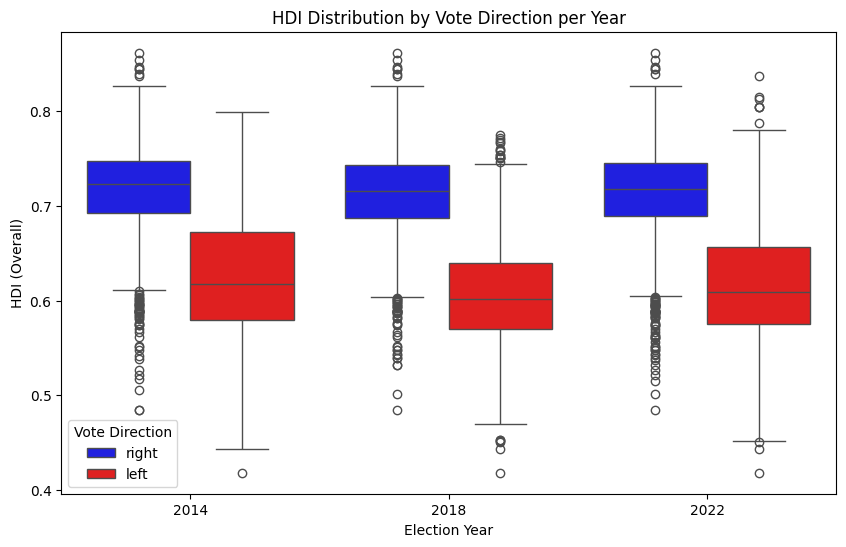

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Custom color palette: match "left" to red and "right" to blue
custom_palette = {
    'left': '#ff0000',
    'right': '#0000ff'
}

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=corr_df,
    x='year',
    y='Overall',
    hue='direction',
    palette=custom_palette
)
plt.title('HDI Distribution by Vote Direction per Year')
plt.ylabel('HDI (Overall)')
plt.xlabel('Election Year')
plt.legend(title='Vote Direction')
plt.show()

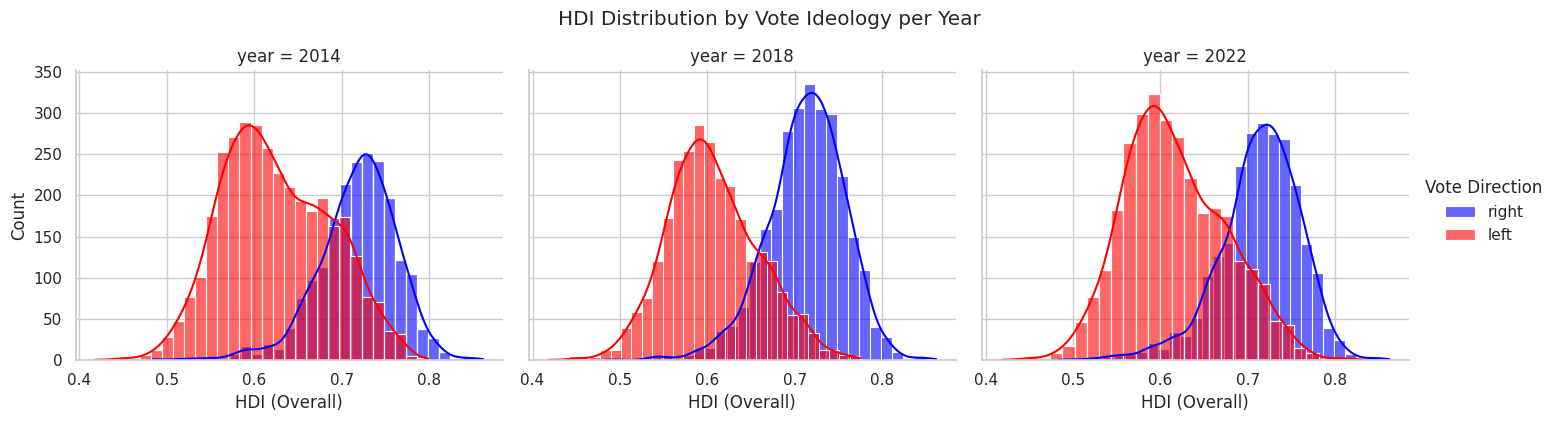

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Create FacetGrid to show a histogram for each year
g = sns.FacetGrid(corr_df, col="year", hue="direction", palette={'left': '#ff0000', 'right': '#0000ff'}, height=4, aspect=1.2)
g.map(sns.histplot, "Overall", bins=30, kde=True, alpha=0.6)
g.add_legend(title="Vote Direction")

g.set_axis_labels("HDI (Overall)", "Count")
g.fig.suptitle("HDI Distribution by Vote Ideology per Year", y=1.05)

plt.savefig('outputs/HDI_Distribution.png')

## Votes from emigrated population

In [ ]:
def process_votes_data_zz(df):
    # Map values in the 'nm_urna_candidato' column
    df['direction'] = df['nm_candidato'].map({
        'JAIR MESSIAS BOLSONARO': 'right',
        'LUIZ INÁCIO LULA DA SILVA': 'left',
        'FERNANDO HADDAD': 'left',
        'AÉCIO NEVES DA CUNHA': 'right',
        'DILMA VANA ROUSSEFF': 'left'
    })
    
    # Filter rows for 'Presidente' and exclude 'ZZ' in 'sg_uf'
    df = df[df['ds_cargo'] == 'Presidente']
    df = df[df['sg_uf'] == 'ZZ']
    
    
    return df

In [ ]:
# Example usage for 2022
votes_df_zz = process_votes_data_zz(combined_votes_df)

# Display the processed DataFrame
votes_df_zz.head()

,sg_uf,nm_municipio,cd_cargo,ds_cargo,nr_candidato,nm_candidato,nm_urna_candidato,sg_partido,ds_composicao_coligacao,nr_turno,...,sq_candidato,nm_tipo_destinacao_votos,sq_eleicao_divulga,aa_eleicao,nm_regiao,pc_votos_validos,qt_votos_nom_validos,qt_votos_concorrentes,year,direction
14740,ZZ,ABIDJÃ,1,Presidente,13,DILMA VANA ROUSSEFF,DILMA,PT,PT / PMDB / PSD / PP / PR / PROS / PDT / PC do...,2,...,280000000083,#NE,680,2014,EXTERIOR,0.7021,33,47,2014,left
14741,ZZ,ABIDJÃ,1,Presidente,45,AÉCIO NEVES DA CUNHA,AÉCIO NEVES,PSDB,PSDB / PMN / SD / DEM / PEN / PTN / PTB / PTC ...,2,...,280000000085,#NE,680,2014,EXTERIOR,0.2979,14,47,2014,right
14742,ZZ,ABU DHABI,1,Presidente,45,AÉCIO NEVES DA CUNHA,AÉCIO NEVES,PSDB,PSDB / PMN / SD / DEM / PEN / PTN / PTB / PTC ...,2,...,280000000085,#NE,680,2014,EXTERIOR,0.8718,136,156,2014,right
14743,ZZ,ABU DHABI,1,Presidente,13,DILMA VANA ROUSSEFF,DILMA,PT,PT / PMDB / PSD / PP / PR / PROS / PDT / PC do...,2,...,280000000083,#NE,680,2014,EXTERIOR,0.1282,20,156,2014,left
14744,ZZ,AMÃ,1,Presidente,13,DILMA VANA ROUSSEFF,DILMA,PT,PT / PMDB / PSD / PP / PR / PROS / PDT / PC do...,2,...,280000000083,#NE,680,2014,EXTERIOR,0.6250,125,200,2014,left


In [ ]:
# Mapping of city names to countries
city_country_mapping = {
    'ABIDJÃ': 'Ivory Coast',
    'ABU DHABI': 'United Arab Emirates',
    'AMÃ': 'Jordan',
    'ANCARA': 'Turkey',
    'ARTIGAS': 'Uruguay',
    'ASSUNÇÃO': 'Paraguay',
    'ATENAS': 'Greece',
    'ATLANTA': 'United States',
    'BANGKOK': 'Thailand',
    'BARCELONA': 'Spain',
    'BEIRUTE': 'Lebanon',
    'BELGRADO': 'Serbia',
    'BERLIM': 'Germany',
    'BISSAU': 'Guinea-Bissau',
    'BOGOTÁ': 'Colombia',
    'BOSTON': 'United States',
    'BRUXELAS': 'Belgium',
    'BUCARESTE': 'Romania',
    'BUDAPESTE': 'Hungary',
    'BUENOS AIRES': 'Argentina',
    'CAIENA': 'French Guiana',
    'CAIRO': 'Egypt',
    'CAMBERRA': 'Australia',
    'CARACAS': 'Venezuela',
    'CHICAGO': 'United States',
    'CIDADE DO CABO': 'South Africa',
    'CIUDAD DEL ESTE': 'Paraguay',
    'CIUDAD GUAYANA': 'Venezuela',
    'COCHABAMBA': 'Bolivia',
    'CONCEPCIÓN': 'Chile',
    'COPENHAGUE-DINA': 'Denmark',
    'CÓRDOBA': 'Argentina',
    'DACAR': 'Senegal',
    'DOHA': 'Qatar',
    'DUBLIN': 'Ireland',
    'DÍLI': 'East Timor',
    'ENCARNACIÓN': 'Paraguay',
    'ESTOCOLMO': 'Sweden',
    'FARO': 'Portugal',
    'FRANKFURT': 'Germany',
    'GENEBRA': 'Switzerland',
    'GEORGETOWN': 'Guyana',
    'GUATEMALA-GUAT': 'Guatemala',
    'HAMAMATSU': 'Japan',
    'HARTFORD': 'United States',
    'HAVANA': 'Cuba',
    'HELSINQUE': 'Finland',
    'HONG KONG-HONG': 'Hong Kong',
    'HOUSTON': 'United States',
    'ISTAMBUL': 'Turkey',
    'JACARTA': 'Indonesia',
    'KINGSTON-JAMA': 'Jamaica',
    'KINSHASA': 'Democratic Republic of the Congo',
    'KUAITE': 'Kuwait',
    'KUALA LUMPUR': 'Malaysia',
    'LA PAZ': 'Bolivia',
    'LAGOS': 'Nigeria',
    'LIMA': 'Peru',
    'LISBOA': 'Portugal',
    'LIUBLIANA': 'Slovenia',
    'LONDRES': 'United Kingdom',
    'LOS ANGELES': 'United States',
    'LUANDA': 'Angola',
    'MADRI': 'Spain',
    'MANILA': 'Philippines',
    'MANÁGUA': 'Nicaragua',
    'MAPUTO': 'Mozambique',
    'MENDOZA': 'Argentina',
    'MIAMI': 'United States',
    'MILÃO': 'Italy',
    'MITSUKAIDO-JAPA': 'Japan',
    'MONTEVIDÉU': 'Uruguay',
    'MONTREAL': 'Canada',
    'MOSCOU': 'Russia',
    'MUNIQUE': 'Germany',
    'MÉXICO-MEXI': 'Mexico',
    'NAGÓIA': 'Japan',
    'NAIRÓBI': 'Kenya',
    'NICOSIA': 'Cyprus',
    'NOVA DELHI': 'India',
    'NOVA YORK': 'United States',
    'OIZUMI-JAPA': 'Japan',
    'OSLO': 'Norway',
    'OTTAWA': 'Canada',
    'PANAMÁ-PAN': 'Panama',
    'PARAMARIBO': 'Suriname',
    'PARIS': 'France',
    'PEDRO JUAN CABALLERO': 'Paraguay',
    'PEQUIM': 'China',
    'PORT OF SPAIN': 'Trinidad and Tobago',
    'PORTO': 'Portugal',
    'PORTO PRÍNCIPE': 'Haiti',
    'PRAGA': 'Czech Republic',
    'PRAIA': 'Cape Verde',
    'PRETÓRIA': 'South Africa',
    'QUITO': 'Ecuador',
    'RABAT': 'Morocco',
    'RAMALLAH-PALE': 'Palestine',
    'RIADE': 'Saudi Arabia',
    'ROMA': 'Italy',
    'ROTTERDÃ': 'Netherlands',
    'SALTO DEL GUAIRÁ': 'Paraguay',
    'SANTIAGO': 'Chile',
    'SEUL': 'South Korea',
    'SINGAPURA-SING': 'Singapore',
    'STA C LA SIERRA-BOLI': 'Bolivia',
    'SUZUKA-JAPA': 'Japan',
    'SYDNEY': 'Australia',
    'SÃO DOMINGOS': 'Dominican Republic',
    'SÃO FRANCISCO': 'United States',
    'SÃO JOSÉ': 'Costa Rica',
    'SÃO SALVADOR': 'El Salvador',
    'TAIPÉ': 'Taiwan',
    'TAKAOKA-JAPA': 'Japan',
    'TEERÃ': 'Iran',
    'TEGUCIGALPA': 'Honduras',
    'TEL AVIV': 'Israel',
    'TORONTO': 'Canada',
    'TOYOHASHI-JAPA': 'Japan',
    'TUNIS': 'Tunisia',
    'TÓQUIO': 'Japan',
    'UEDA-JAPA': 'Japan',
    'VANCOUVER': 'Canada',
    'VARSÓVIA': 'Poland',
    'VIENA': 'Austria',
    'WASHINGTON': 'United States',
    'WELLINGTON': 'New Zealand',
    'WINDHOEK': 'Namibia',
    'XANGAI': 'China',
    'ZAGREB': 'Croatia',
    'ZURIQUE': 'Switzerland',
    'ACCRA-GANA': 'Ghana',
    'BRATISLAVA': 'Slovakia',
    'CANTÃO': 'China',
    'CHUY': 'Uruguay',
    'DAR ES SALAAM': 'Tanzania',
    'GUATEMALA': 'Guatemala',
    'HANÓI': 'Vietnam',
    'KATMANDU': 'Nepal',
    'KIEV': 'Ukraine',
    'KINGSTON-JAMAICA': 'Jamaica',
    'LUSACA': 'Zambia',
    'MASCATE': 'Oman',
    'NASSAU': 'Bahamas',
    'RIO BRANCO': 'Brazil',
    'TALIN': 'Estonia',
    'ABUJA': 'Nigeria',
    'ACCRA': 'Ghana',
    'ADIS ABEBA': 'Ethiopia',
    'AMSTERDÃ': 'Netherlands',
    'ARGEL': 'Algeria',
    'ASTANA': 'Kazakhstan',
    'BAGDÁ': 'Iraq',
    'BAKU': 'Azerbaijan',
    'BAMAKO': 'Mali',
    'BAREIN': 'Bahrain',
    'BELMOPAN': 'Belize',
    'BRAZZAVILLE': 'Republic of the Congo',
    'BRIDGETOWN': 'Barbados',
    'CASTRIES': 'Saint Lucia',
    'COBIJA': 'Bolivia',
    'COLOMBO': 'Sri Lanka',
    'CONACRI': 'Guinea',
    'COPENHAGUE': 'Denmark',
    'COTONOU': 'Benin',
    'DAMASCO': 'Syria',
    'GABORONE': 'Botswana',
    'HARARE': 'Zimbabwe',
    'HONG KONG': 'Hong Kong',
    'IAUNDÊ': 'Cameroon',
    'IEREVAN': 'Armenia',
    'IQUITOS': 'Peru',
    'ISLAMABADE': 'Pakistan',
    'LIBREVILLE': 'Gabon',
    'LILONGUE': 'Malawi',
    'LOMÉ': 'Togo',
    'MALABO': 'Equatorial Guinea',
    'MEXICO': 'Mexico',
    'MUMBAI': 'India',
    'PANAMA': 'Panama',
    'PASO LOS LIBRES': 'Argentina',
    'PUERTO IGUAZÚ': 'Argentina',
    'PUERTO QUIJARRO': 'Bolivia',
    'RAMALLAH': 'Palestine',
    'RIVERA': 'Uruguay',
    'SAINT JOHNS': 'Antigua and Barbuda',
    'SANTA CRUZ DE LA SIERRA': 'Bolivia',
    'SARAJEVO': 'Bosnia and Herzegovina',
    'SINGAPURA': 'Singapore',
    'ST GEORGES DE LOYAPOCK': 'French Guiana',
    'SÃO TOMÉ': 'São Tomé and Príncipe',
    'SÓFIA': 'Bulgaria',
    'TBILISI': 'Georgia',
    'TIRANA': 'Albania',
    'TRÍPOLI': 'Libya',
    'UAGADUGU': 'Burkina Faso',
    'VATICANO': 'Vatican City',
    'YANGON': 'Myanmar'
}


In [ ]:
# Assuming your DataFrame is named df and has a column 'city'
votes_df_zz['country'] = votes_df_zz['nm_municipio'].map(city_country_mapping)

In [ ]:
votes_df_zz.head()

,sg_uf,nm_municipio,cd_cargo,ds_cargo,nr_candidato,nm_candidato,nm_urna_candidato,sg_partido,ds_composicao_coligacao,nr_turno,...,nm_tipo_destinacao_votos,sq_eleicao_divulga,aa_eleicao,nm_regiao,pc_votos_validos,qt_votos_nom_validos,qt_votos_concorrentes,year,direction,country
14740,ZZ,ABIDJÃ,1,Presidente,13,DILMA VANA ROUSSEFF,DILMA,PT,PT / PMDB / PSD / PP / PR / PROS / PDT / PC do...,2,...,#NE,680,2014,EXTERIOR,0.7021,33,47,2014,left,Ivory Coast
14741,ZZ,ABIDJÃ,1,Presidente,45,AÉCIO NEVES DA CUNHA,AÉCIO NEVES,PSDB,PSDB / PMN / SD / DEM / PEN / PTN / PTB / PTC ...,2,...,#NE,680,2014,EXTERIOR,0.2979,14,47,2014,right,Ivory Coast
14742,ZZ,ABU DHABI,1,Presidente,45,AÉCIO NEVES DA CUNHA,AÉCIO NEVES,PSDB,PSDB / PMN / SD / DEM / PEN / PTN / PTB / PTC ...,2,...,#NE,680,2014,EXTERIOR,0.8718,136,156,2014,right,United Arab Emirates
14743,ZZ,ABU DHABI,1,Presidente,13,DILMA VANA ROUSSEFF,DILMA,PT,PT / PMDB / PSD / PP / PR / PROS / PDT / PC do...,2,...,#NE,680,2014,EXTERIOR,0.1282,20,156,2014,left,United Arab Emirates
14744,ZZ,AMÃ,1,Presidente,13,DILMA VANA ROUSSEFF,DILMA,PT,PT / PMDB / PSD / PP / PR / PROS / PDT / PC do...,2,...,#NE,680,2014,EXTERIOR,0.6250,125,200,2014,left,Jordan


In [ ]:
votes_df_zz_plot = votes_df_zz[['country', 'direction', 'nm_municipio', 'year', 'pc_votos_validos']]
votes_df_zz_plot = votes_df_zz_plot.dropna()
votes_df_zz_plot.head()

,country,direction,nm_municipio,year,pc_votos_validos
14740,Ivory Coast,left,ABIDJÃ,2014,0.7021
14741,Ivory Coast,right,ABIDJÃ,2014,0.2979
14742,United Arab Emirates,right,ABU DHABI,2014,0.8718
14743,United Arab Emirates,left,ABU DHABI,2014,0.1282
14744,Jordan,left,AMÃ,2014,0.6250


In [ ]:
# Group by 'sg_uf' and 'nm_municipio', and find the row with the maximum 'pc_votos_validos'
result_zz = votes_df_zz_plot.loc[
    votes_df_zz_plot.groupby(['country', 'nm_municipio', 'year'])['pc_votos_validos'].idxmax()
]

# Select only the relevant columns
result_zz = result_zz[['country', 'nm_municipio', 'direction', 'pc_votos_validos', 'year']]

# Display the result_zz
result_zz.head()

,country,nm_municipio,direction,pc_votos_validos,year
14864,Angola,LUANDA,right,0.5962,2014
32268,Angola,LUANDA,right,0.5759,2018
49158,Angola,LUANDA,left,0.5561,2022
14778,Argentina,BUENOS AIRES,right,0.5792,2014
32170,Argentina,BUENOS AIRES,left,0.5343,2018


In [ ]:
# import pandas as pd
# from geopy.geocoders import Nominatim
# import time

# # Your DataFrame
# # df = pd.read_csv("your_data.csv")  # or already loaded

# geolocator = Nominatim(user_agent="city_mapper")

# def get_location(row):
#     try:
#         location = geolocator.geocode(f"{row['nm_municipio']}, {row['country']}")
#         time.sleep(1)  # to respect usage limits
#         if location:
#             return pd.Series([location.latitude, location.longitude])
#     except:
#         return pd.Series([None, None])

# result_zz[['lat', 'lon']] = result_zz.apply(get_location, axis=1)


In [ ]:
# result_zz.to_csv('result_zz.csv', index=False)

In [ ]:
result_zz = pd.read_csv('data/result_zz.csv')
result_zz.head()

,country,nm_municipio,direction,pc_votos_validos,year,lat,lon
0,Angola,LUANDA,right,0.5962,2014,-8.82727,13.243951
1,Angola,LUANDA,right,0.5759,2018,-8.82727,13.243951
2,Angola,LUANDA,left,0.5561,2022,-8.82727,13.243951
3,Argentina,BUENOS AIRES,right,0.5792,2014,-34.60837,-58.444058
4,Argentina,BUENOS AIRES,left,0.5343,2018,-34.60837,-58.444058


In [ ]:
# Optional: only needed if cities have multiple entries per year
winner_df = result_zz.groupby(['nm_municipio', 'country', 'year', 'lat', 'lon'])['direction'] \
                     .agg(lambda x: x.value_counts().idxmax()).reset_index()

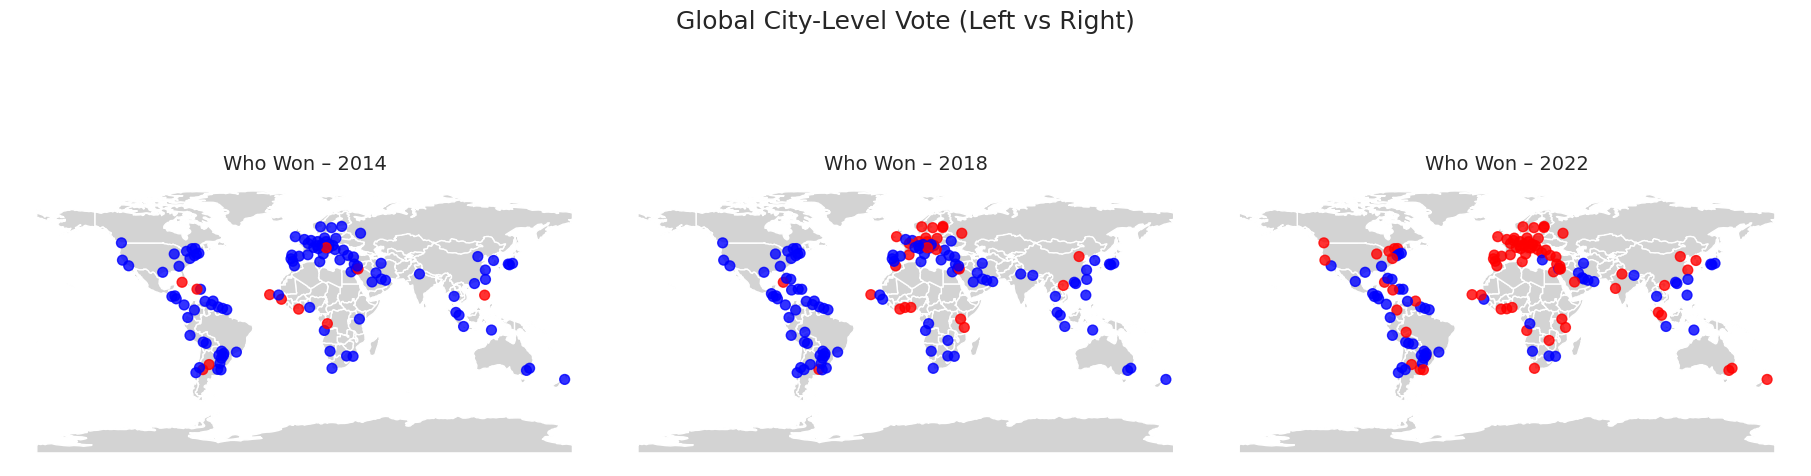

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Load base map
world = gpd.read_file('/home/paulobeckhauser/Documents/dtu/social_data/finalAssignment/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

# Convert your DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(result_zz['lon'], result_zz['lat'])]
gdf = gpd.GeoDataFrame(result_zz, geometry=geometry, crs="EPSG:4326")

# Colors for directions
direction_colors = {'left': 'red', 'right': 'blue'}

# Plot one map per year
years = gdf['year'].unique()
fig, axes = plt.subplots(1, len(years), figsize=(6 * len(years), 6), constrained_layout=True)

for ax, year in zip(axes, sorted(years)):
    world.plot(ax=ax, color='lightgrey', edgecolor='white')
    year_data = gdf[gdf['year'] == year]
    year_data.plot(ax=ax,
                   color=year_data['direction'].map(direction_colors),
                   markersize=50, alpha=0.8)
    ax.set_title(f"Who Won – {year}", fontsize=14)
    ax.axis('off')

plt.suptitle("Global City-Level Vote (Left vs Right)", fontsize=18)
plt.savefig('outputs/global_vote_direction.png', dpi=300)

## Interactive Plot (City and State)

In [9]:
import geopandas as gpd
import folium
from branca.colormap import linear
from folium.plugins import GroupedLayerControl


def election_layer_state(year: int, gdf: gpd.GeoDataFrame) -> folium.FeatureGroup:
    fg = folium.FeatureGroup(
        name=str(year),
        show=(year == 2022),
        control=True,
    )

    cmap = linear.RdBu_11.scale(0, 1).to_step(12)

    def style_fn(feature):
        row = gdf.iloc[int(feature["id"])]
        pct = row["percentage_right"]
        return {
            "fillColor": cmap(pct),
            "color": "black",
            "weight": 0.3,
            "fillOpacity": 0.7,
        }

    tooltip = folium.GeoJsonTooltip(
        fields=[
            "state",
            "percentage_right",
        ],
        aliases=[
            "State",
            "% votes",
        ],
        sticky=True,
    )

    folium.GeoJson(gdf, tooltip=tooltip, style_function=style_fn).add_to(fg)

    return fg


def make_multi_year_map(
    outfile="elections_state.html",
):
    probe_gdf = gpd.read_file("state_2022.gpkg").to_crs(4326)
    minx, miny, maxx, maxy = probe_gdf.total_bounds
    brazil_bounds = [[miny, minx], [maxy, maxx]]
    centre = [(miny + maxy) / 2, (minx + maxx) / 2]

    m = folium.Map(
        location=centre,
        zoom_start=5,  # initial rough zoom
        tiles="CartoDB positron",
        control_scale=True,
        max_bounds=True,  # users cannot pan outside brazil_bounds
    )
    m.fit_bounds(brazil_bounds)

    KEEP = [
        "geometry",
        "state",
        "percentage_right",
    ]

    overlay_groups = []
    for yr in [2014, 2018, 2022]:
        gdf = (
            gpd.read_file(f"state_{yr}.gpkg")
            .to_crs(4326)
            .reset_index(drop=False)
            .rename(columns={"index": "id"})[KEEP]
        )
        gdf["geometry"] = gdf["geometry"].simplify(
            0.02,
            preserve_topology=True,
        )
        fg = election_layer_state(yr, gdf)
        fg.add_to(m)
        overlay_groups.append(fg)

    GroupedLayerControl(
        groups={"Election year": overlay_groups},
        exclusive_groups=True,
        collapsed=False,
    ).add_to(m)

    overlay_groups[-1].add_to(m)

    colourbar = linear.RdBu_11.scale(0, 1).to_step(12)
    colourbar.caption = "Left ← vote share → Right"
    colourbar.position = "bottomleft"
    colourbar.add_to(m)

    m.save(outfile)
    return outfile


if __name__ == "__main__":
    path = make_multi_year_map()
    print(f"wrote: {path}")


ModuleNotFoundError: No module named 'folium'